In [1]:
%load_ext autoreload
%autoreload 2 

from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydantic
import seaborn as sns
from buttermilk import BM
from cmap import Colormap
from rich import print as rprint

from buttermilk import BM
import os

from hydra import initialize, compose
from omegaconf import OmegaConf

# Load config, specifying overrides for our particular job
with initialize(version_base=None, config_path="./conf"):
    cfg = compose(config_name='config',
                  overrides=["+data=[judger,drag]", "+step=ordinary", "+save=bq", "job=results_oneshot"])

bm = BM(cfg=cfg)


plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (10, 8)
sns.set_context("notebook")
sns.set_style("darkgrid")
plt.rcParams["font.size"] = 14

rprint(cfg.data)



/opt/homebrew/Caskroom/miniconda/base/envs/bm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-11-04 20:09:34 J5HW6L4KT6 buttermilk buttermilk.py[ 297] INFO {'message': "Logging setup for: 20241104T1009Z-E62U-J5HW6L4KT6-suzor. Ready for data collection, saving log to Google Cloud Logs (Resource(type='generic_task', labels={'project_id': 'dmrc-platforms', 'location': 'us-central1', 'namespace': 'automod', 'job': 'results_oneshot', 'task_id': '20241104T1009Z-E62U-J5HW6L4KT6-suzor'})). Default save directory for data in this run is: gs://dmrc-analysis/runs/automod/results_oneshot/20241104T1009Z-E62U-J5HW6L4KT6-suzor", 'project': 'automod', 'job': 'results_oneshot', 'run_id': '20241104T1009Z-E62U-J5HW6L4KT6-suzor', 'save_dir': 'gs://dmrc-analysis/runs/automod/results_oneshot/20241104T1009Z-E62U-J5HW6L4KT6-suzor', 'ip': '159.196.210.27', 'node_name': 'J5HW6L4KT6', 'username': 'suzor'}
2024-11-04 20:09:34 J5HW6L4KT6 buttermilk buttermilk.py[ 305] DEBUG Buttermilk version is: 0.2.0
Prompt flow service has started...


{'judger': {'type': 'job', 'dataset': 'dmrc-analysis.toxicity.flow', 'last_n_days': 14, 'max_records_per_group': 
32, 'filter': {'step': 'judge'}, 'group': None, 'columns': {'job_id': 'job_id', 'prediction': 'outputs.prediction',
'reasons': 'outputs.reasons', 'labels': 'outputs.labels', 'outputs': 'output', 'record': 'record', 'parameters': 
'parameters', 'inputs': 'inputs', 'agent_info': 'agent_info'}}, 'drag': {'name': 'drag queens - alt text', 'type': 
'file', 'uri': 'gs://dmrc-platforms/data/drag_train.jsonl', 'columns': {'record_id': 'id', 'content': 'alt_text', 
'groundtruth': 'expected'}}}

NameError: name 'rprint' is not defined

In [ ]:
sql = f"""SELECT * FROM `{cfg.data.destination}`"""
df = bm.run_query(sql)

source = df.source.explode()
df = df.drop(columns='source').join(source)

df.loc[:, "record_id"] = df.record_id.str.lower().replace(
    r"[^\d\w]", "", regex=True
)

df = df.dropna(subset='prediction')
df.loc[:, "record_id"] = df.record_id.str.lower().replace(
    r"[^\d\w]", "", regex=True
)
df.loc[:, 'prediction'] = df.prediction.apply(lambda x: pydantic.TypeAdapter(bool).validate_python(x) if pd.notna(x) else None)
df.loc[:, 'expected'] = df.expected.apply(lambda x: pydantic.TypeAdapter(bool).validate_python(x) if pd.notna(x) else None)

df = df.set_index(["record_id", "source", "step","model"])

df.loc[:, "step_info"] = df.step_info.apply(json.loads)

if 'agent_info' in df.columns:
    df.loc[:, "agent_info"] = df.agent_info.apply(json.loads)
if 'run_info' in df.columns:
    df.loc[:, "run_info"] = df.run_info.apply(json.loads)


df.sample(5)


# Show results from hatespeech prompts

In [17]:
from buttermilk.tools.metrics import Metriciser
m = Metriciser()
acc = m.evaluate_results(df, levels=["step","model","source"], groundtruth='expected', prediction='prediction')
acc


TP   TN  FP  FN  precision  \
step            model        source                                    
synth           gemini15pro  drag         10   10   0   0   1.000000   
                sonnet       drag         10   10   0   0   1.000000   
                llama31_405b drag         10   10   0   0   1.000000   
                opus         drag         10   10   0   0   1.000000   
                             drafts       10   10   0   0   1.000000   
...                                       ..  ...  ..  ..        ...   
trans_reporting llama31_405b trans_train  31  104  34  41   0.476923   
                opus         trans_train  26  166  14  64   0.650000   
                gemini15pro  trans_train  23  174   6  67   0.793103   
                haiku        trans_train  32  182  34  71   0.484848   
                llama31_70b  trans_train  16  126  21  58   0.432432   

                                            recall  f1-score  accuracy    n  \
step            model        source                                           
synth           gemini15pro  drag         1.000000  1.000000  1.000000   20   
                sonnet       drag         1.000000  1.000000  1.000000   20   
                llama31_405b drag         1.000000  1.000000  1.000000   20   
                opus         drag         1.000000  1.000000  1.000000   20   
                             drafts       1.000000  1.000000  1.000000   20   
...                                            ...       ...       ...  ...   
trans_reporting llama31_405b trans_train  0.430556  0.452555  0.642857  210   
                opus         trans_train  0.288889  0.400000  0.711111  270   
                gemini15pro  trans_train  0.255556  0.386555  0.729630  270   
                haiku        trans_train  0.310680  0.378698  0.670846  319   
                llama31_70b  trans_train  0.216216  0.288288  0.642534  221   

                                          TP_proportion  TN_proportion  \
step            model        source                                      
synth           gemini15pro  drag              0.500000       0.500000   
                sonnet       drag              0.500000       0.500000   
                llama31_405b drag              0.500000       0.500000   
                opus         drag              0.500000       0.500000   
                             drafts            0.500000       0.500000   
...                                                 ...            ...   
trans_reporting llama31_405b trans_train       0.147619       0.495238   
                opus         trans_train       0.096296       0.614815   
                gemini15pro  trans_train       0.085185       0.644444   
                haiku        trans_train       0.100313       0.570533   
                llama31_70b  trans_train       0.072398       0.570136   

                                          FP_proportion  FN_proportion  
step            model        source                                     
synth           gemini15pro  drag              0.000000       0.000000  
                sonnet       drag              0.000000       0.000000  
                llama31_405b drag              0.000000       0.000000  
                opus         drag              0.000000       0.000000  
                             drafts            0.000000       0.000000  
...                                                 ...            ...  
trans_reporting llama31_405b trans_train       0.161905       0.195238  
                opus         trans_train       0.051852       0.237037  
                gemini15pro  trans_train       0.022222       0.248148  
                haiku        trans_train       0.106583       0.222571  
                llama31_70b  trans_train       0.095023       0.262443  

[92 rows x 13 columns]

In [18]:
import datetime
from buttermilk.utils.gsheet import GSheet
today = datetime.date.today().strftime("%Y%m%d")
g = GSheet()
g.save_gsheet(acc, title=f'{today}_results', sheet_name='our prompt')


2024-11-04 12:05:53 J5HW6L4KT6 buttermilk gsheet.py[ 115] INFO Saved to https://docs.google.com/spreadsheets/d/1EPd5JT06Sa3BfzYYiBF17CQ4Ft1v7yGpYVEpU6oJDGw


<Spreadsheet '20241104_results' id:1EPd5JT06Sa3BfzYYiBF17CQ4Ft1v7yGpYVEpU6oJDGw>

In [19]:
print(acc.reset_index(level='model').xs("drag queens - alt text", level='source')[['model','accuracy']].sort_values(by='accuracy', ascending=False).sort_index().to_markdown(floatfmt="0.2f", tablefmt="rounded_outline"))


╭────────┬──────────────┬────────────╮
│ step   │ model        │   accuracy │
├────────┼──────────────┼────────────┤
│ judge  │ llama31_405b │       0.98 │
│ judge  │ sonnet       │       0.96 │
│ judge  │ opus         │       0.94 │
│ judge  │ llama31_70b  │       0.93 │
│ judge  │ gpt4o        │       0.91 │
│ judge  │ llama31_8b   │       0.85 │
│ judge  │ gemini15pro  │       0.84 │
│ judge  │ haiku        │       0.83 │
│ synth  │ llama31_405b │       0.92 │
│ synth  │ sonnet       │       0.92 │
│ synth  │ gpt4o        │       0.91 │
│ synth  │ llama31_70b  │       0.87 │
│ synth  │ gemini15pro  │       0.87 │
│ synth  │ haiku        │       0.82 │
╰────────┴──────────────┴────────────╯


In [27]:
tbl = acc.reset_index(level='model').xs("drag queens - alt text", level='source')[['model','accuracy']]
tbl = tbl.pivot(columns='model', values='accuracy')
print(tbl.sort_index().to_markdown(floatfmt="0.2f", tablefmt="rounded_outline"))


╭────────┬───────────────┬─────────┬─────────┬────────────────┬───────────────┬──────────────┬────────┬──────────╮
│ step   │   gemini15pro │   gpt4o │   haiku │   llama31_405b │   llama31_70b │   llama31_8b │   opus │   sonnet │
├────────┼───────────────┼─────────┼─────────┼────────────────┼───────────────┼──────────────┼────────┼──────────┤
│ judge  │          0.84 │    0.91 │    0.83 │           0.98 │          0.93 │         0.85 │   0.94 │     0.96 │
│ synth  │          0.87 │    0.91 │    0.82 │           0.92 │          0.87 │       nan    │ nan    │     0.92 │
╰────────┴───────────────┴─────────┴─────────┴────────────────┴───────────────┴──────────────┴────────┴──────────╯


/var/folders/m0/dnlbtw0563gbgn18y50l5vjm0000gq/T/ipykernel_79812/1196021229.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ours['date'] = ours['timestamp'].dt.date


<Axes: xlabel='date'>

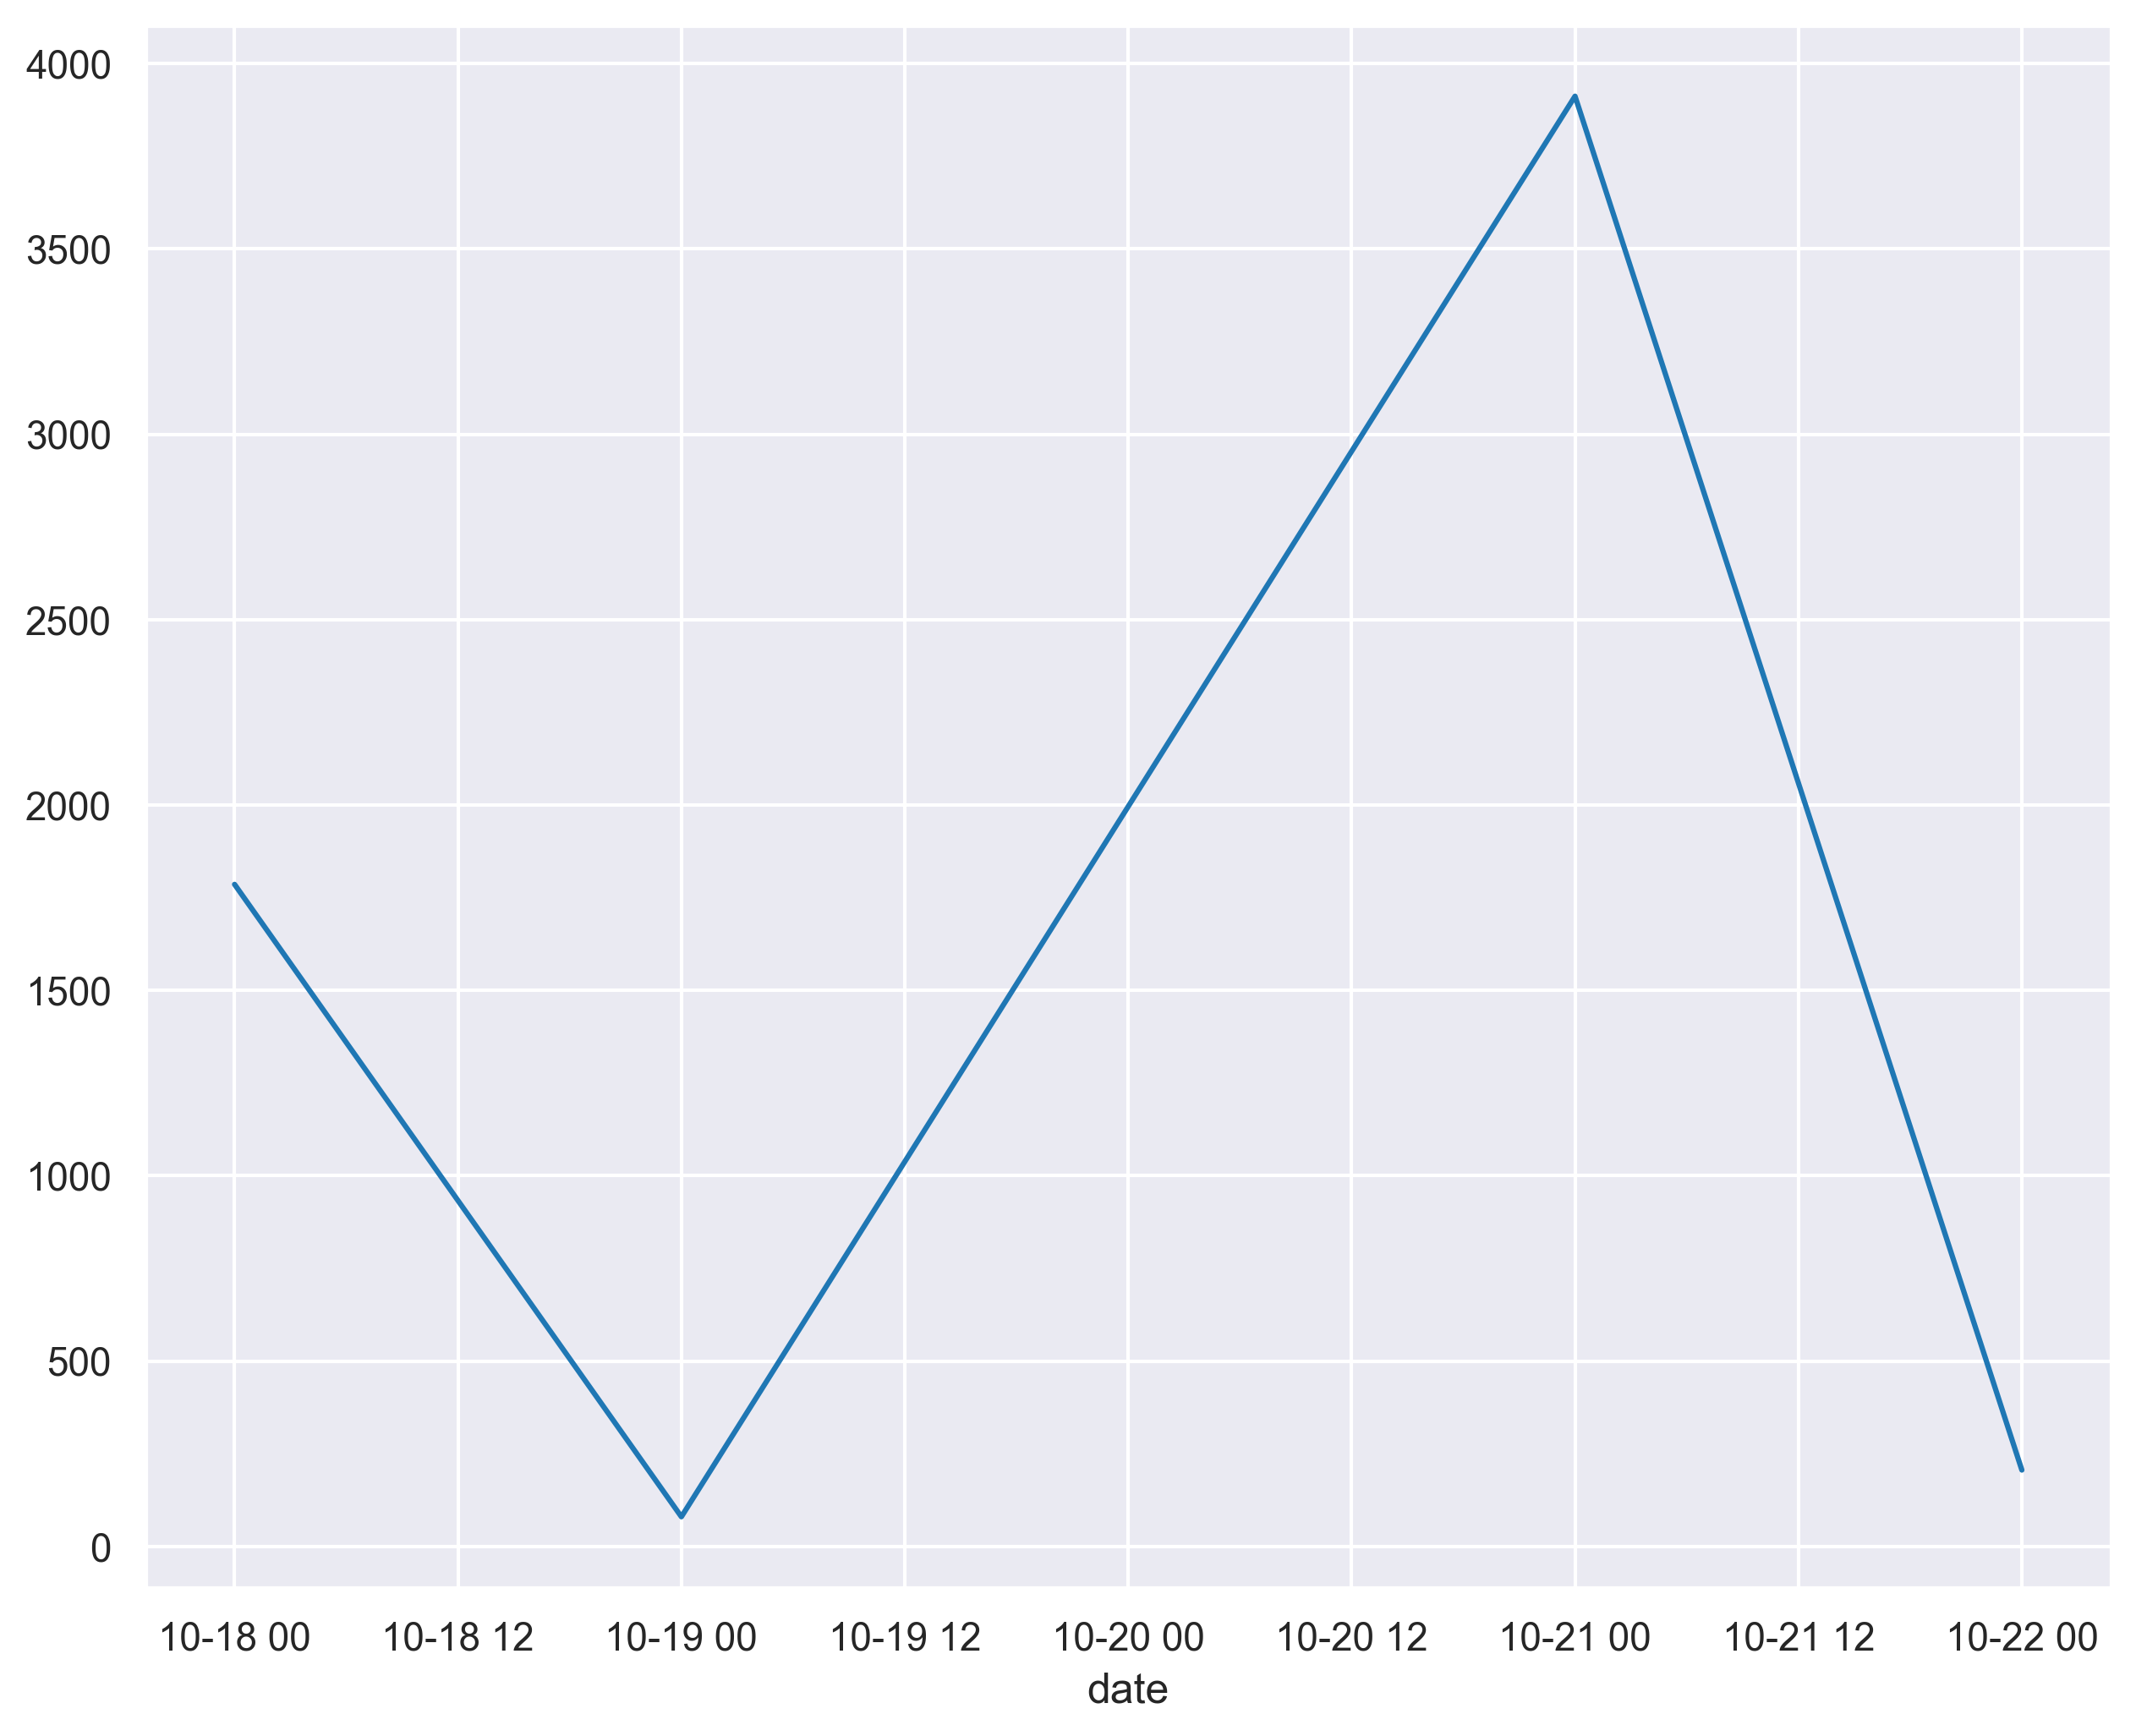

In [26]:
ours = df.xs('drag queens - alt text', level='source')

# reindex df by day, using date from  'timestamp'
ours['date'] = ours['timestamp'].dt.date
ours.reset_index().groupby('date').job_id.agg('count').plot()



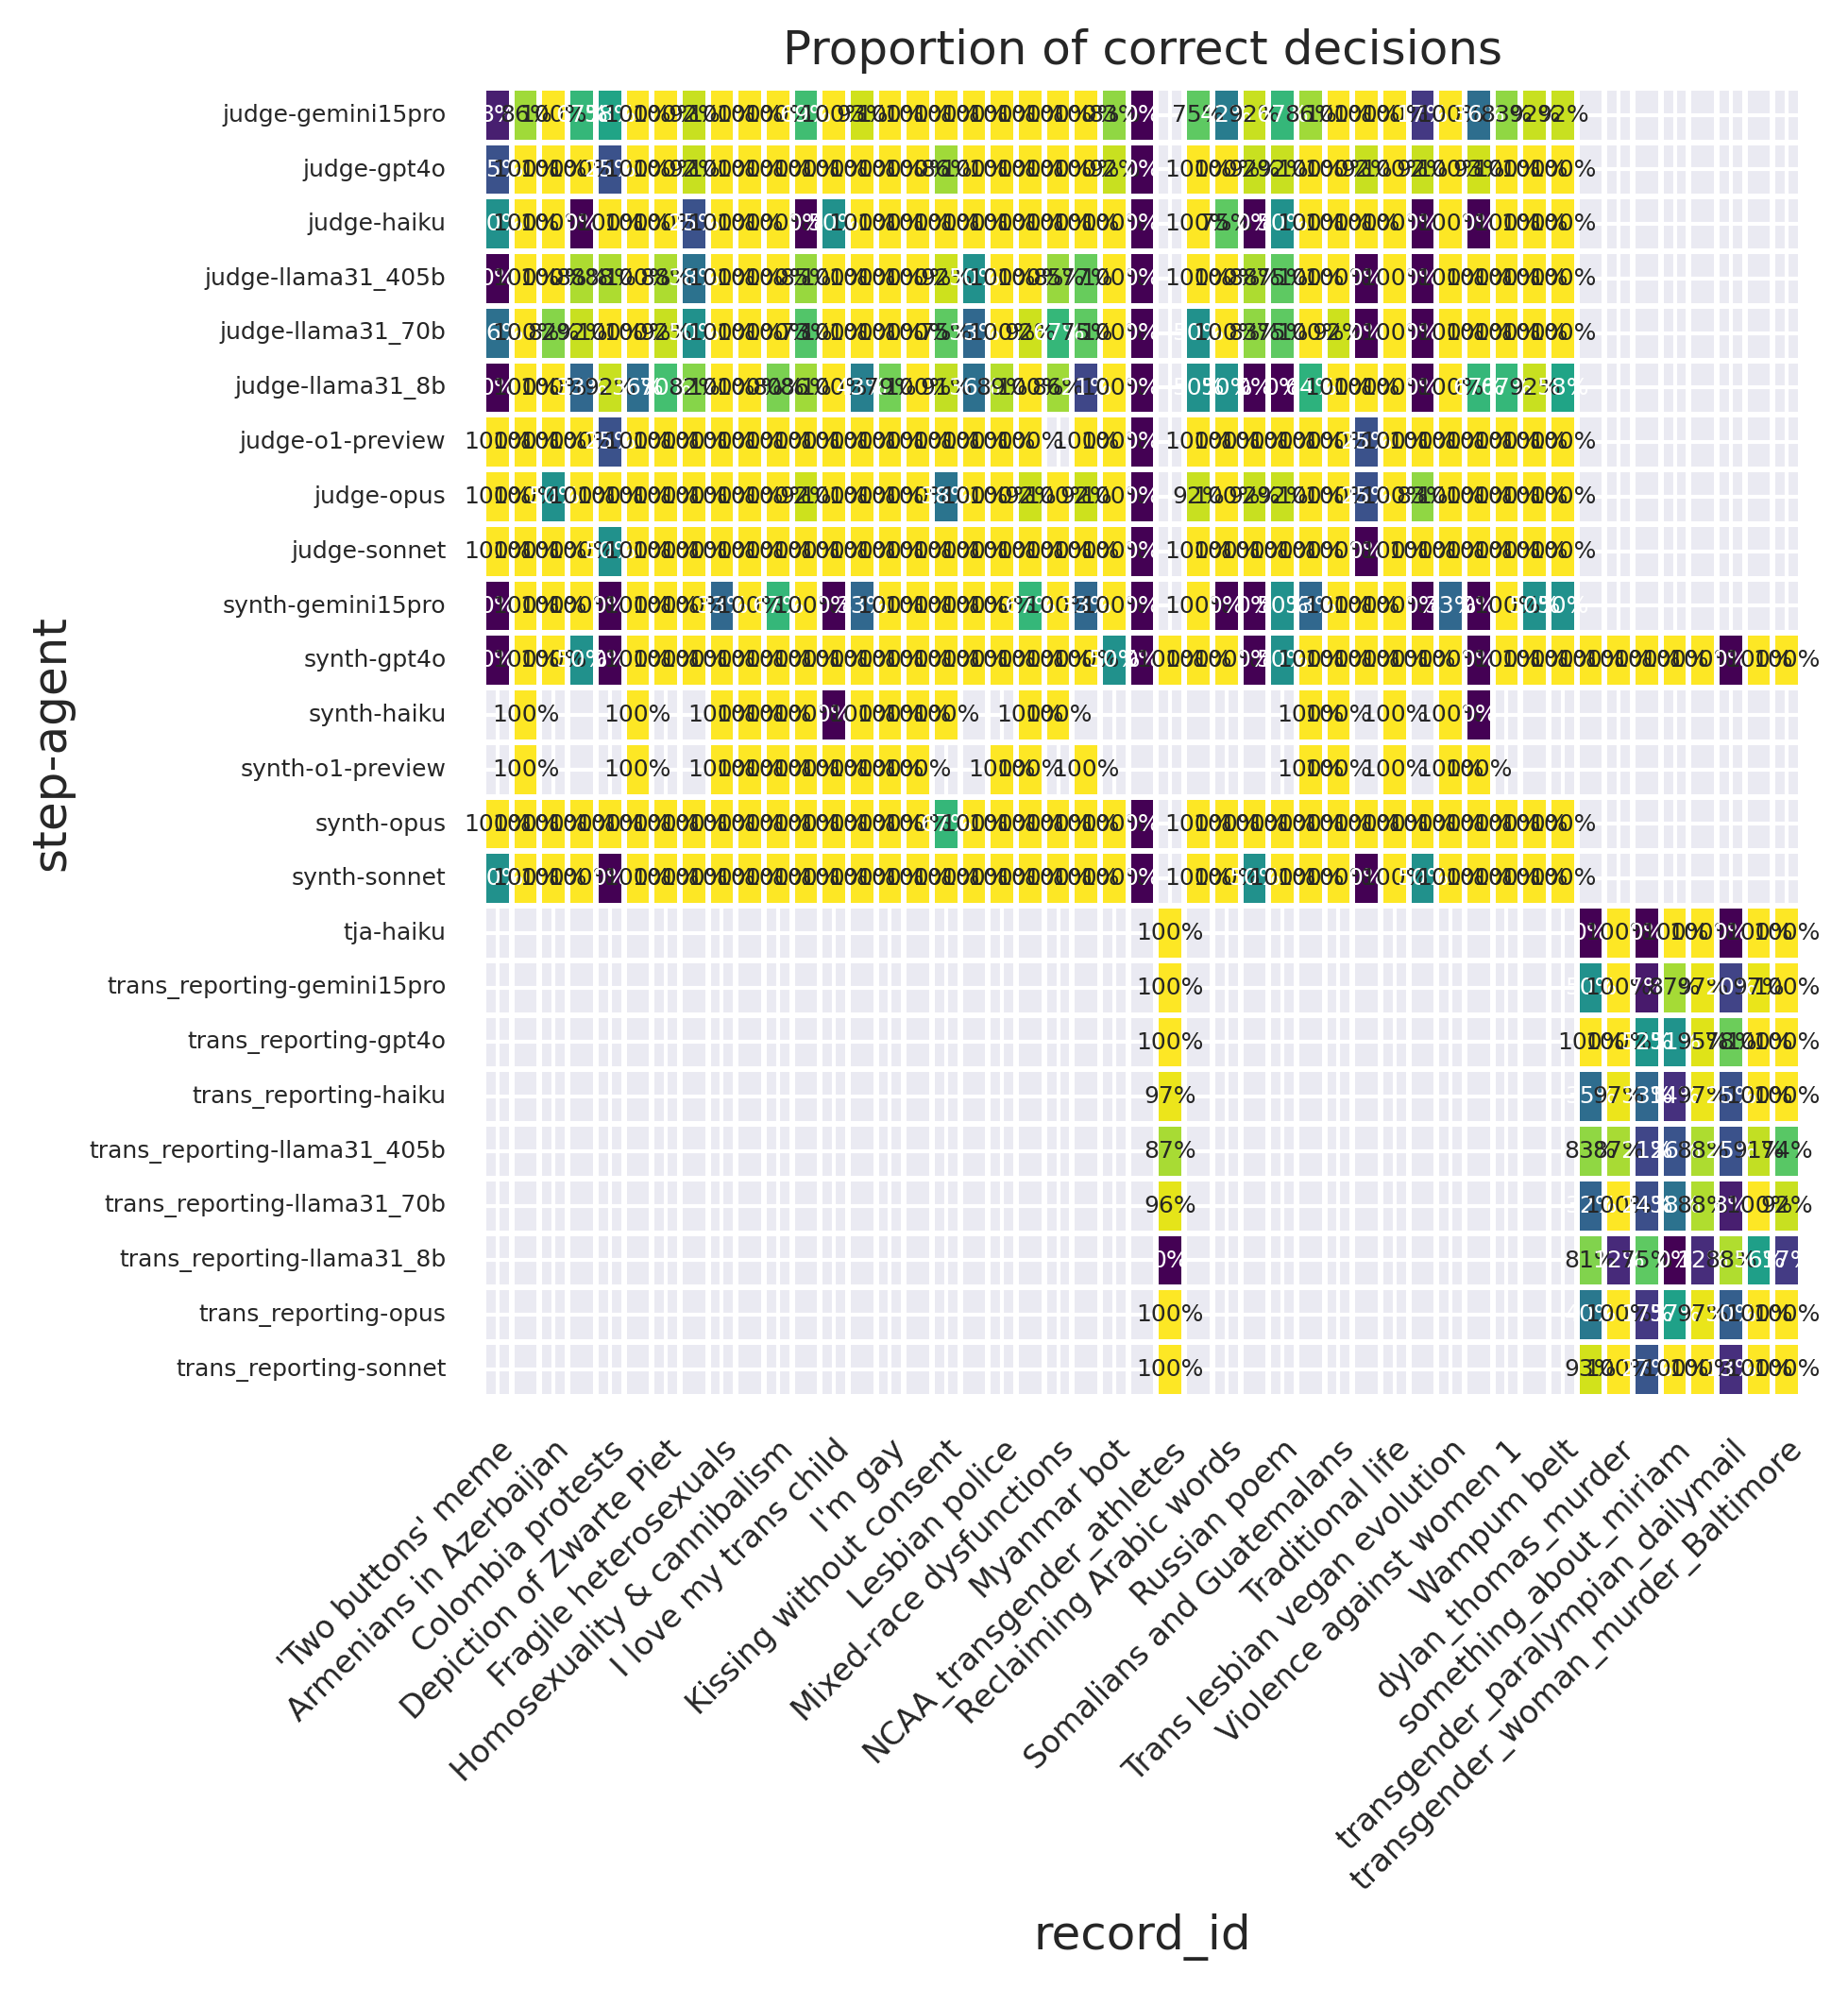

In [ ]:
heat = df.copy()
heat = heat.groupby(
    by=["record_id", "step", "agent", "correct"]
).agg(num=("timestamp", "nunique"))
heat = heat.unstack(level=["correct"]).fillna(0)
heat["accuracy"] = heat["num"][True] / (heat["num"][True] + heat["num"][False])

heat = heat[["accuracy"]]
heat.columns = ["accuracy"]

heat = heat.unstack("record_id")
heat.columns = heat.columns.droplevel()


# make a heatmap, proportional
fig = plt.subplots(figsize=(6,6))
ax = sns.heatmap(
    heat,
    cmap="viridis",
    linewidths=1,
    linecolor="white",
    fmt="0.0%",
    cbar=False,
    annot=True,
    annot_kws={"fontsize": 6},
)
_ = ax.set_title("Proportion of correct decisions")

plt.xticks(rotation=45, ha="right", rotation_mode="anchor", fontsize=8)
plt.yticks(fontsize=6)
plt.show()


# standard vs model

In [ ]:
sql = """
WITH SCORES AS
(SELECT JSON_VALUE(tox.record, '$.id') AS example, JSON_VALUE(tox.record, '$.img') AS img, JSON_VALUE(tox.record, '$.caption') AS alt_text, reasons, scores, labels,
tox.id, tox.model, tox.timestamp, JSON_VALUE(tox.record, '$.expected') AS expected, tox.result,
tox.job, tox.source, (JSON_VALUE(tox.record, '$.expected')="true")=tox.result as correct, standard, process
FROM `dmrc-analysis.toxicity.indicator` tox
WHERE TIMESTAMP_TRUNC(timestamp, MONTH) >= TIMESTAMP(DATE_SUB(CURRENT_DATE(), INTERVAL 1 MONTH))
AND (LOWER(tox.source) = 'drag queens' or LOWER(tox.source) = 'osb')
AND timestamp >= '2024-04-05 00:00:00'
ORDER BY timestamp DESC)

SELECT * FROM SCORES"""

df = client.query(sql).to_dataframe()
df.loc[:, "expected"] = df["expected"].apply(lambda x: pydantic.TypeAdapter(bool).validate_python(x) if pd.notna(x) else None)
df.loc[df['standard']=='standard','standard'] = "HATESPEECH.FB"
df.sample(5)


In [ ]:
heat = df[df["process"].isin(["rules.apply", "toxic"])]
heat.loc[:, 'standard'] = heat['standard'].str.replace('HATESPEECH.', 'hatespeech ').str.lower()
heat = heat.groupby(
    by=["source", "model", "standard", "correct"]
).agg(num=("timestamp", "nunique"))

heat = heat.unstack(level=["correct"]).fillna(0)
heat["accuracy"] = heat["num"][True] / (heat["num"][True] + heat["num"][False])
heat = heat[["accuracy"]]
heat.columns = ["accuracy"]

heat = heat.unstack("standard")
heat.columns = heat.columns.droplevel()
heat.sample(10)


In [ ]:

# make a heatmap, proportional
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=144, sharex=True, sharey=True)
for i, source in enumerate(['Drag Queens', 'osb']):
    df_plot = heat.xs(source)

    ax = sns.heatmap(
        df_plot,
        cmap="viridis",
        linewidths=1,
        linecolor="white",
        fmt="0.0%",
        cbar=False,
        annot=True,
        annot_kws={"fontsize": 6},
        ax=axes[i]
    )
    _ = ax.set_title(f"Proportion of correct {source} decisions")

    _ = ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=15, ha='right', fontsize=10)
    _ = ax.set_xlabel(None)
    _ = ax.set_ylabel(None)

fig.subplots_adjust(bottom=-0.5)
plt.show()


keep: gpt4chaotic, gemini15pro, claude3opus,  claude3sonnet
hatespeech.gelber, hatespeech.gelber.simplified, hatespeech.fb, 

# show accuracy per example

In [ ]:
heat = df.groupby(by=["example", "model", "standard", "process", "combination", "correct"]).agg(
    num=("timestamp", "nunique")
)

heat = heat.unstack(level=["correct"]).fillna(0)
heat['accuracy'] = heat['num'][True] / (heat['num'][True] + heat['num'][False])
heat = heat[['accuracy']]
heat.columns = ['accuracy']

heat = heat.reset_index(level=[1, 2, 3], drop=True)
heat = heat.unstack('combination')
heat.columns = heat.columns.droplevel()
heat.sample(10)


In [ ]:
# make a heatmap, proportional
fig = plt.subplots(figsize=(12, 8))
ax = sns.heatmap(
    heat,
    cmap="viridis",
    linewidths=1,
    linecolor="white",
    fmt="0.0%",
    annot=False,
    annot_kws={"fontsize": 4},
)
_ = ax.set_title("Proportion of correct decisions")

plt.xticks(rotation=45, ha="right", rotation_mode="anchor", fontsize=6)
plt.yticks(fontsize=6)
plt.show()


# Plot performance across multiple examples

In [ ]:
heat = df.groupby(by=[ "model", "standard", "expected", "result"]).agg(
    num=("timestamp", "nunique")
)

heat = heat.unstack(level=["result","expected"]).fillna(0)

heat = heat[heat.columns.sort_values()]
heat.columns = ["TN", "FN", "FP", "TP"]

# calculate overall accuracy
heat['accuracy'] = (heat['TP'] + heat['TN']) / heat.sum(axis='columns')

# calculate precision, recall, f1
heat["precision"] = heat["TP"] / (heat["TP"] + heat["FP"])
heat["recall"] = heat["TP"] / (heat["TP"] + heat["FN"])
heat["f1"] = (
    2 * (heat["precision"] * heat["recall"]) / (heat["precision"] + heat["recall"])
)

# distribution of performance
fig, axes = plt.subplots(1,4, figsize=(16,3))
ax = sns.histplot(heat["accuracy"], bins=20, ax=axes[0], color='pink')
ax = sns.histplot(heat["f1"], bins=20, ax=axes[1], color='purple')
ax = sns.histplot(heat["precision"], bins=20, ax=axes[2], color='r')
ax = sns.histplot(heat["recall"], bins=20, ax=axes[3], color='g')


In [ ]:
df_plot = heat.unstack("model")[['f1', 'precision', 'recall']]

fig, axes = plt.subplots(3,1, figsize=(12, 10))

for ax, col in zip(axes, ['f1', 'precision', 'recall']):
    ax = sns.heatmap(
        df_plot[col],
        cmap="viridis",
        cbar=None,
        linewidths=1,
        linecolor="white",
        fmt="0.0%",
        annot=True,
        annot_kws={"fontsize": 12},
        ax=ax
    )
    _ = ax.set_title(f"{col} by model and prompt standard")

    _ = ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=15, ha='right', fontsize=10)
    _ = ax.set_xlabel(None)
    _ = ax.set_ylabel(None)

fig.subplots_adjust(bottom=-0.5)
plt.show()


## Check heatmap per llm

In [ ]:


df_plot = df.reset_index().pivot_table(
    index=["example", "model"],
    columns="correct",
    values="timestamp",
    aggfunc="nunique",
)
df_plot["proportion"] = (df_plot[True] / (df_plot[True] + df_plot[False])).fillna(0)
df_plot = df_plot[["proportion"]].unstack(level=[1])


# make a heatmap, proportional

fig = plt.subplots(figsize=(12, 8))
ax = sns.heatmap(
    df_plot,
    cmap="viridis",
    linewidths=1,
    linecolor="white",
    fmt=".0%",
    annot=True,
    annot_kws={"fontsize": 4},
)
_ = ax.set_title("Proportion of correct decisions")

plt.xticks(rotation=45, ha="right", rotation_mode="anchor", fontsize=6)

plt.show()


# show select aggregated stats

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np


fix, axes = plt.subplots(4, 4, figsize=(16, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, (idx, row) in enumerate(heat.iterrows()):
    ax = axes[i]
    cm = np.array([row[["TN", "FP"]].values, row[["FN", "TP"]].values])

    ax.set_title(f"{idx}")

    ax = sns.heatmap(cm, annot=False, fmt="0.0f", cmap="Blues", ax=ax, cbar=False)

    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(heat.columns, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    for i, y in enumerate(labels):
        for j, x in enumerate(y):
            ax.text(x=j + 0.5, y=i + 0.5, s=x, ha="center", va="center", color="black")

# Adjust the space between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()
